# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## Практика

In [ ]:
!pip install -U keras-tuner

In [43]:
from __future__ import print_function


from keras.datasets import imdb
# import pandas as pd
# import math
import keras
import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import save_model
# from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import GRU, LSTM
from tensorflow.keras.layers import Dropout, Activation
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


import tensorflow as tf
# from pickle import dump,load
# import warnings
# warnings.simplefilter("ignore", UserWarning)


from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt




In [7]:

def build_model(hp):


    model = Sequential()

    model.add(Embedding(max_features, 128))
    activation_ = hp.Choice('activation',values=['relu', 'sigmoid'])
    model.add(LSTM(128, activation = activation_))


    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4])))


    return model

In [8]:
tuner= RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=1
        )

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}


In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [12]:
tuner.search(
        x=X_train,
        y=Y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2, 
        callbacks = [stop_early]
)

Trial 20 Complete [00h 09m 00s]
val_accuracy: 0.8274000287055969

Best val_accuracy So Far: 0.8331999778747559
Total elapsed time: 01h 50m 55s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
Dropout_rate: 0.0
learning_rate: 0.01
activation: sigmoid
Score: 0.8331999778747559
Trial summary
Hyperparameters:
Dropout_rate: 0.2
learning_rate: 0.0001
activation: sigmoid
Score: 0.8324000239372253
Trial summary
Hyperparameters:
Dropout_rate: 0.5
learning_rate: 0.01
activation: sigmoid
Score: 0.83160001039505
Trial summary
Hyperparameters:
Dropout_rate: 0.1
learning_rate: 0.0001
activation: sigmoid
Score: 0.8303999900817871
Trial summary
Hyperparameters:
Dropout_rate: 0.4
learning_rate: 0.0001
activation: sigmoid
Score: 0.8281999826431274
Trial summary
Hyperparameters:
Dropout_rate: 0.30000000000000004
learning_rate: 0.0001
activation: sigmoid
Score: 0.8274000287055969
Trial summary
Hyperparameters:
Dropout_rate: 0.2
learning_rate: 0.0001
activation: relu
Score: 0.8271999955177307
Trial summary
Hyperparameters:
Dropout_rate: 0.4
learning_rate: 0.01
activation: sigmoid
Score: 0.8262000

In [ ]:
Генерация из посева: for days a
for days and the madd the madd the madd the madd the madd the madd the madd the madd the madd the madd the mad

In [ ]:
import numpy as np
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential


# построчное чтение из примера с текстом 
with open("alice_in_wonderland.txt", 'rb') as _in:
    lines = []
    for line in _in:
        line = line.strip().lower().decode("ascii", "ignore")
        if len(line) == 0:
            continue
        lines.append(line)
text = " ".join(lines)
chars = set([c for c in text])
nb_chars = len(chars)


# создание индекса символов и reverse mapping чтобы передвигаться между значениями numerical
# ID и определенный символ. Numerical ID будет соответсвовать колонке
# число при использовании one-hot кодировки для представление входов символов
char2index = {c: i for i, c in enumerate(chars)}
index2char = {i: c for i, c in enumerate(chars)}

# для удобства выберете фиксированную длину последовательность 10 символов 
SEQLEN, STEP = 10, 1
input_chars, label_chars = [], []

# конвертация data в серии разных SEQLEN-length субпоследовательностей
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i: i + SEQLEN])
    label_chars.append(text[i + SEQLEN])


# Вычисление one-hot encoding входных последовательностей X и следующего символа (the label) y

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1


# установка ряда метапамертров  для нейронной сети и процесса тренировки
BATCH_SIZE, HIDDEN_SIZE = 128, 128
NUM_ITERATIONS = 4 # 25 должно быть достаточно
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100


# Create a super simple recurrent neural network. There is one recurrent
# layer that produces an embedding of size HIDDEN_SIZE from the one-hot
# encoded input layer. This is followed by a Dense fully-connected layer
# across the set of possible next characters, which is converted to a
# probability score via a standard softmax activation with a multi-class
# cross-entropy loss function linking the prediction to the one-hot
# encoding character label.

'''
Создание очень простой рекуррентной нейронной сети. В ней будет один реккурентный закодированный входной слой. За ним последует полносвязный слой связанный с набором возможных следующих символов, которые конвертированы в вероятностные результаты через стандартную softmax активацию с multi-class cross-encoding loss функцию ссылающуются на предсказание one-hot encoding лейбл символа
'''

model = Sequential()
model.add(
    GRU(  # вы можете изменить эту часть на LSTM или SimpleRNN, чтобы попробовать альтернативы
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(SEQLEN, nb_chars),
        unroll=True
    )
)
model.add(Dense(nb_chars))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")


# выполнение серий тренировочных и демонстрационных итераций 
for iteration in range(NUM_ITERATIONS):

    # для каждой итерации запуск передачи данных в модель 
    print("=" * 50)
    print("Итерация #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Select a random example input sequence.
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    # для числа шагов предсказаний использование текущей тренируемой модели 
    # конструирование one-hot encoding для тестирования input и добавление предсказания.
    print("Генерация из посева: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):

        # здесь one-hot encoding.
        X_test = np.zeros((1, SEQLEN, nb_chars))
        for j, ch in enumerate(test_chars):
            X_test[0, j, char2index[ch]] = 1

        # осуществление предсказания с помощью текущей модели.
        pred = model.predict(X_test, verbose=0)[0]
        y_pred = index2char[np.argmax(pred)]

        # вывод предсказания добавленного к тестовому примеру 
        print(y_pred, end="")

        # инкрементация тестового примера содержащего предсказание
        test_chars = test_chars[1:] + y_pred
print()


In [14]:
# лучшая модель

model_tune = tuner.get_best_models(num_models=1)

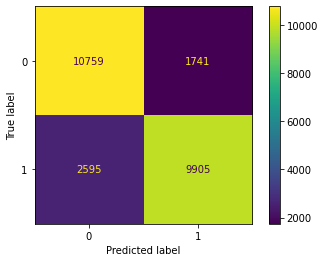

accuracy: 0.82656
Метрика accuracy выросла до: 0.82656


In [34]:
predictions = model_tune[0].predict(X_test)
predictions_label = np.array(predictions > 0.5).astype(int)


cm = confusion_matrix(Y_test, predictions_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# так как класы в таргете примерно сбалансированы можно применить и accuracy_score
acc = accuracy_score(Y_test, predictions_label)
print(f'accuracy: {acc}')


print(f'Метрика accuracy выросла до: {acc}')
# Удалось улучщить за счет более сложной архитектуры модели

In [35]:
model_tune[0].summary()

# Save the model to disk.
model_tune[0].save('model_tune_HW5.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


Попробовал улучшить метрику, но не получилось, так как использовал слишком малое число max_trials=20, для экономии времени, а попробовать побольшене успел - время сдачи проекта вышло. Из плюсов - применил EarlyStopping (в которой patience тоже взял видимо слишком меленькой)

Давайте также посмотрим пример в которм будет использоваться другой класс задач - генерация текста на основе тренировочного текста. В задачу нейросети будет входить обучившись на тексте Алиса в стране чудес и начать генерировать текст похожий на тот, что можно встретить в этой книге. Также в этом примере будет использоваться GRU.

# Решение пункта 2.

In [37]:

with open("alice_in_wonderland.txt", 'rb') as _in:
    lines = []
    for line in _in:
        line = line.strip().lower().decode("ascii", "ignore")
        if len(line) == 0:
            continue
        lines.append(line)
text = " ".join(lines)
chars = set([c for c in text])
nb_chars = len(chars)

In [38]:
char2index = {c: i for i, c in enumerate(chars)}
index2char = {i: c for i, c in enumerate(chars)}

SEQLEN, STEP = 10, 1
input_chars, label_chars = [], []

# конвертация data в серии разных SEQLEN-length субпоследовательностей
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i: i + SEQLEN])
    label_chars.append(text[i + SEQLEN])


# Вычисление one-hot encoding входных последовательностей X и следующего символа (the label) y

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=bool)
y = np.zeros((len(input_chars), nb_chars), dtype=bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1

In [39]:
# установка ряда метапамертров  для нейронной сети и процесса тренировки
BATCH_SIZE, HIDDEN_SIZE = 128, 128
NUM_ITERATIONS = 1 # 25 должно быть достаточно
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

In [44]:
# Create a super simple recurrent neural network. There is one recurrent
# layer that produces an embedding of size HIDDEN_SIZE from the one-hot
# encoded input layer. This is followed by a Dense fully-connected layer
# across the set of possible next characters, which is converted to a
# probability score via a standard softmax activation with a multi-class
# cross-entropy loss function linking the prediction to the one-hot
# encoding character label.

'''
Создание очень простой рекуррентной нейронной сети. В ней будет один реккурентный закодированный входной слой. За ним последует полносвязный слой связанный с набором возможных следующих символов, которые конвертированы в вероятностные результаты через стандартную softmax активацию с multi-class cross-encoding loss функцию ссылающуются на предсказание one-hot encoding лейбл символа
'''

model = Sequential()
model.add(
    GRU(  # вы можете изменить эту часть на LSTM или SimpleRNN, чтобы попробовать альтернативы
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(SEQLEN, nb_chars),
        unroll=True
    )
)
model.add(Dense(nb_chars))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")


# выполнение серий тренировочных и демонстрационных итераций 
for iteration in range(NUM_ITERATIONS):

    # для каждой итерации запуск передачи данных в модель 
    print("=" * 50)
    print("Итерация #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Select a random example input sequence.
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    # для числа шагов предсказаний использование текущей тренируемой модели 
    # конструирование one-hot encoding для тестирования input и добавление предсказания.
    print("Генерация из посева: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):

        # здесь one-hot encoding.
        X_test = np.zeros((1, SEQLEN, nb_chars))
        for j, ch in enumerate(test_chars):
            X_test[0, j, char2index[ch]] = 1

        # осуществление предсказания с помощью текущей модели.
        pred = model.predict(X_test, verbose=0)[0]
        y_pred = index2char[np.argmax(pred)]

        # вывод предсказания добавленного к тестовому примеру 
        print(y_pred, end="")

        # инкрементация тестового примера содержащего предсказание
        test_chars = test_chars[1:] + y_pred
print()

Итерация #: 0
1241/1241 [==============================] - 31s 23ms/step - loss: 2.3243
Генерация из посева: d cunning 
d cunning the said the said the said the said the said the said the said the said the said the said the said t


При увеличением количества эпох и итераций удалось добиться более осмысленное содержание, хотя четкие критерии осмысленности сомнительны.